In [55]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Read the Folder and compute Mfcc features

In [56]:
# Function to compute MFCC features for an audio file
def compute_mfcc(audio_filepath, n_mfcc=40):
    y, sr = librosa.load(audio_filepath, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T 

# Function to process data and compute MFCCs
def process_data(data_folder, folder_path):
    mfcc_list = []
    label_list = []

    total_files = len(data_folder)

    for i, label in enumerate(data_folder):
        label_dir = os.path.join(folder_path, label)

        # Get the list of audio files in the label folder
        audio_files = [filename for filename in os.listdir(label_dir) if filename.endswith(".wav")]

        for j, audio_filename in enumerate(audio_files):
            audio_filepath = os.path.join(label_dir, audio_filename)
            print(f'Processing file {i+1}/{total_files}, Audio {j+1}/{len(audio_files)}: {audio_filepath} (Label: {label})')

            # Compute MFCC for the audio file
            mfcc = compute_mfcc(audio_filepath)

            # Append MFCC and label to the lists
            mfcc_list.append(mfcc)
            label_list.append(label)

    # Calculate the mean MFCCs for each audio file
    train_mfcc_array = np.array([mfcc.mean(axis=0) for mfcc in mfcc_list])

    label_array = np.array(label_list)

    return train_mfcc_array, label_array

# Path to train data folder
train_data_folder = 'Dataset'

# Load train data (labels are based on folder names)
train_data = [label for label in os.listdir(train_data_folder) if os.path.isdir(os.path.join(train_data_folder, label))]

# Process train data
print('Processing train data...')
train_mfcc_array, train_labels = process_data(train_data, train_data_folder)

print('Train MFCC shape:', train_mfcc_array.shape)  # Should be (number_of_samples_train, 40)

Processing train data...
Processing file 1/5, Audio 1/521: Dataset\angry\1083_ITH_ANG_XX.wav (Label: angry)
Processing file 1/5, Audio 2/521: Dataset\angry\1083_ITS_ANG_XX.wav (Label: angry)
Processing file 1/5, Audio 3/521: Dataset\angry\1083_IWL_ANG_XX.wav (Label: angry)
Processing file 1/5, Audio 4/521: Dataset\angry\1083_IWW_ANG_XX.wav (Label: angry)
Processing file 1/5, Audio 5/521: Dataset\angry\1083_MTI_ANG_XX.wav (Label: angry)
Processing file 1/5, Audio 6/521: Dataset\angry\1083_TAI_ANG_XX.wav (Label: angry)
Processing file 1/5, Audio 7/521: Dataset\angry\1083_TIE_ANG_XX.wav (Label: angry)
Processing file 1/5, Audio 8/521: Dataset\angry\1083_TSI_ANG_XX.wav (Label: angry)
Processing file 1/5, Audio 9/521: Dataset\angry\1083_WSI_ANG_XX.wav (Label: angry)
Processing file 1/5, Audio 10/521: Dataset\angry\1084_DFA_ANG_XX.wav (Label: angry)
Processing file 1/5, Audio 11/521: Dataset\angry\1084_IEO_ANG_HI.wav (Label: angry)
Processing file 1/5, Audio 12/521: Dataset\angry\1084_IEO_AN

In [57]:
print(train_labels.shape)
print(train_mfcc_array.shape)
print(train_labels)
print(train_mfcc_array)

(2550,)
(2550, 40)
['angry' 'angry' 'angry' ... 'Sad' 'Sad' 'Sad']
[[-3.2082272e+02  8.6709396e+01  2.1695654e+01 ... -5.4276624e+00
  -4.3263516e+00 -9.5436835e-01]
 [-2.8113181e+02  7.1554619e+01  2.8309124e+01 ... -4.1252489e+00
  -3.0279107e+00 -3.6779633e+00]
 [-3.4080463e+02  1.0102588e+02  2.8844055e+01 ... -4.8491812e+00
  -2.5732973e+00 -9.6462083e-01]
 ...
 [-3.5894528e+02  6.5211906e+01  4.5034374e+01 ...  3.0934117e+00
  -2.5708284e+00 -2.5785348e+00]
 [-4.0828275e+02  6.4439598e+01  3.6183121e+01 ... -2.0079744e+00
  -3.3611531e+00  3.6131901e-01]
 [-4.0115601e+02  5.2519684e+01  3.7783588e+01 ...  2.3881571e+00
  -2.1853216e+00 -2.6633117e+00]]


Reshaping the features for CNN and encoding of Labels using Label Encoder

In [58]:
X_train, X_test, y_train, y_test = train_test_split(train_mfcc_array, train_labels, test_size=0.10, random_state=42)

# Print the shapes of the training and testing sets
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_test:', y_test.shape)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# One-hot encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical one-hot encoding
num_classes = 5
y_train_one_hot = np.eye(num_classes)[y_train_encoded]
y_test_one_hot = np.eye(num_classes)[y_test_encoded]

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train_one_hot.shape)
print('y_test shape:', y_test_one_hot.shape)

Shape of X_train: (2295, 40)
Shape of X_test: (255, 40)
Shape of y_train: (2295,)
Shape of y_test: (255,)
X_train shape: (2295, 40, 1)
X_test shape: (255, 40, 1)
y_train shape: (2295, 5)
y_test shape: (255, 5)


CNN architecture with Early stoping Criteria in order to prevent overfitting 

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 38, 64)            256       
                                                                 
 batch_normalization_30 (Bat  (None, 38, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 19, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_31 (Conv1D)          (None, 17, 128)           24704     
                                                                 
 batch_normalization_31 (Bat  (None, 17, 128)          512       
 chNormalization)                                                
                                                     

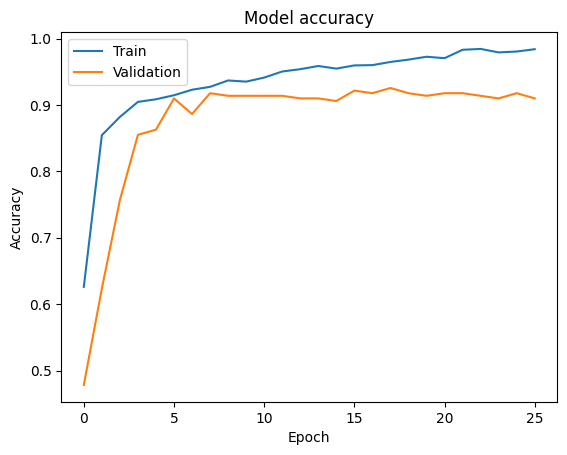

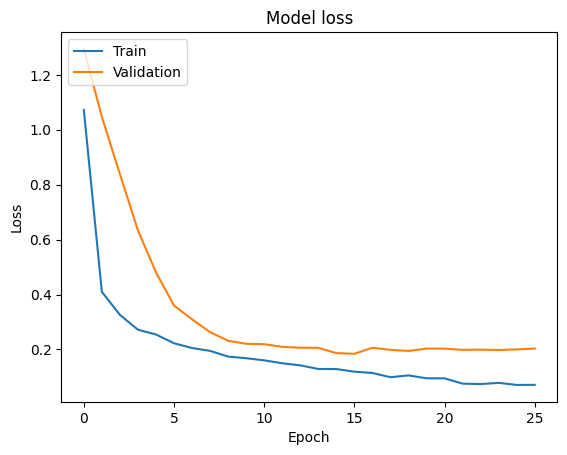

In [59]:
# Define the CNN architecture
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(40, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))  

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
model.summary()
# Train the model
history = model.fit(X_train, y_train_one_hot, validation_data=(X_test, y_test_one_hot), 
                    epochs=200, batch_size=64, verbose=1, callbacks=[early_stopping, reduce_lr])

# Save the model to a file
model.save('model.h5')

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Testing of Model 

8/8 [==============================] - 0s 3ms/step
Testing Accuracy: 0.9215686274509803


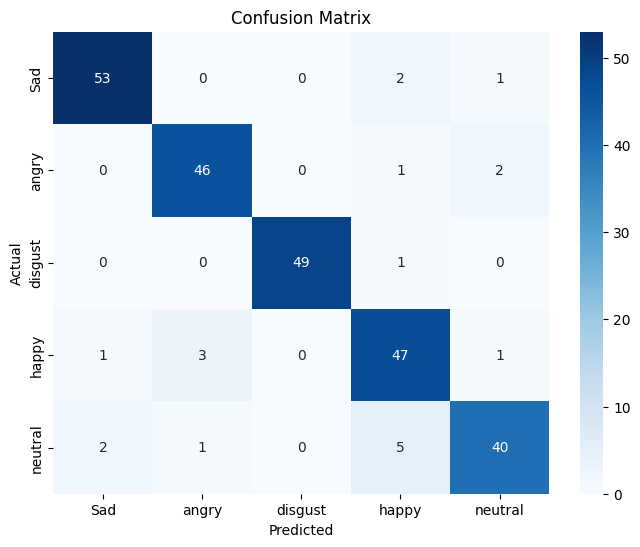

In [60]:
# Make predictions on the test data
predictions = model.predict(X_test)

# Compute Testing Accuracy
accuracy = accuracy_score(np.argmax(y_test_one_hot, axis=1), np.argmax(predictions, axis=1))
print('Testing Accuracy:', accuracy)

# Compute Confusion Matrix
confusion = confusion_matrix(np.argmax(y_test_one_hot, axis=1), np.argmax(predictions, axis=1))

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()